In [ ]:
from google.colab import drive, files, data_table
drive.mount('/content/drive', force_remount=True)
data_table.enable_dataframe_formatter()

%cd /content/drive/MyDrive/Capstone/
!ls

Mounted at /content/drive
/content/drive/MyDrive/Capstone
 cam.jpg			'First Standup.mp4'
'Capstone notes.gslides'	 model.png
'Capstone Proposal.gdoc'	 Models
 Codes				 RSNA_Screening_Mammogram_Dataset
'Copy of Capstone Report.gdoc'


In [ ]:
!mkdir /content/.kaggle
!cp /content/drive/MyDrive/Capstone/Codes/Modules/kaggle.json /content/.kaggle/

In [ ]:
!cp /content/drive/MyDrive/Capstone/Codes/Modules/data_splitter.py /content
!cp /content/drive/MyDrive/Capstone/Codes/Modules/data_loader.py /content
!cp /content/drive/MyDrive/Capstone/Codes/Modules/feature_extraction.py /content
!cp /content/drive/MyDrive/Capstone/Codes/Modules/run_model.py /content
!cp /content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/train.csv /content

In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00


In [ ]:
pip install python-gdcm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 91.9 MB/s eta 0:00:00


In [ ]:
pip install -U pylibjpeg[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 968.5/968.5 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.4 MB/s eta 0:00:00


In [ ]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00


# Importing library and metadata

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from sklearn.decomposition import IncrementalPCA, MiniBatchNMF

import random
from tqdm import tqdm
import pickle
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display
import cv2


try:
  import data_splitter as ds
  import data_loader as dl
  import feature_extraction as fex
  import run_model as rm
except:
  pass

In [ ]:
import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm

In [ ]:
metadata = pd.read_csv('/content/train.csv')
metadata.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
print('Total image file: ', metadata.image_id.nunique())
print('Total patient id: ', metadata.patient_id.nunique())
print('Mean image per patient: ', (metadata.image_id.nunique()/metadata.patient_id.nunique()))

Total image file:  54706
Total patient id:  11913
Mean image per patient:  4.592126248635944


# Getting the training set

In [ ]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [ ]:
set(splitter.train.keys()).intersection(set(splitter.test.keys()))

set()

In [ ]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

In [ ]:
metadata = metadata[metadata['patient_id'].isin(train_ids)]

In [ ]:
# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


## Sample only 10 patients data

In [ ]:
random.seed(42)
sample_ids = random.sample(train_ids, k=10)
sample_meta = metadata[metadata['patient_id'].isin(sample_ids)]
sample_meta.head()

<ipython-input-46-d0c60caa5393>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample_ids = random.sample(train_ids, k=10)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
6104,2,16628,408489380,L,CC,54.0,0,0,0,0.0,0,NaN,29,True
6105,2,16628,942357410,L,MLO,54.0,0,0,0,0.0,0,NaN,29,True
6106,2,16628,14387862,R,CC,54.0,0,0,0,NaN,0,NaN,29,False
6107,2,16628,482999873,R,MLO,54.0,0,0,0,NaN,0,NaN,29,False
7388,1,17845,430821356,L,MLO,63.0,0,0,0,0.0,1,C,49,True


In [ ]:
sample_splitter = ds.DataSplitter(sample_meta, verbose=True)

Total patient_id in training set:  8
Total patient_id in test set:  2
Total image_id in training set:  42
Total image_id in test set:  9
Total patient_id in training set:  6
Total patient_id in calibration set:  2
Total image_id in training set:  34
Total image_id in calibration set:  8


In [ ]:
# getting cross-validation folds
RANDOM_STATE = 42
sample_label_by_img = sample_splitter.labels
sample_cv_patient, sample_cv_img = sample_splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  4
----Total image_id in training set:  19
----Total patient_id in validation set:  2
----Total image_id in validation set:  15
--Fold:  1
----Total patient_id in training set:  5
----Total image_id in training set:  29
----Total patient_id in validation set:  1
----Total image_id in validation set:  5
--Fold:  2
----Total patient_id in training set:  5
----Total image_id in training set:  28
----Total patient_id in validation set:  1
----Total image_id in validation set:  6
--Fold:  3
----Total patient_id in training set:  5
----Total image_id in training set:  30
----Total patient_id in validation set:  1
----Total image_id in validation set:  4
--Fold:  4
----Total patient_id in training set:  5
----Total image_id in training set:  30
----Total patient_id in validation set:  1
----Total image_id in validation set:  4


In [ ]:
save_path = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

for patient_id in sample_ids:
  img_ids = sample_meta[sample_meta['patient_id']==patient_id].image_id.unique()
  for img_id in img_ids:
    dl.load(save_path, patient_id, img_id)

File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is 

## Example of mammogram DICOM image

In [ ]:
dcm = pydicom.dcmread('/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/28381/170258909.dcm')
print(dcm)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.28381.1.170258909
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.28381.1.170258909
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184630.383919'
(0010, 0020) Patient ID                          LO: '28381'
(0018, 11a0) Body Part Thickness                 DS: '64.0'
(001

In [ ]:
print(dcm.file_meta)

(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.28381.1.170258909
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'


(4096, 3328)


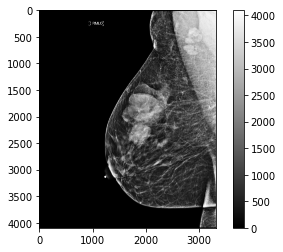

In [ ]:
print(dcm.pixel_array.shape)
plt.imshow(dcm.pixel_array, cmap='gray')

plt.colorbar()
plt.show()

In [ ]:
img = dl.read_and_preprocess('/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/28381', img_size=(512, 512, 1), image_id=170258909, normalize=(-1, 1))
img.shape

TensorShape([512, 512, 1])

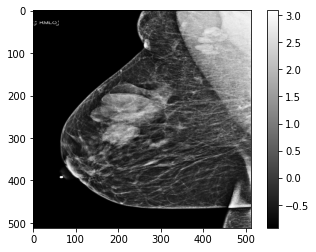

In [ ]:
plt.imshow(img.numpy(), cmap='gray')

plt.colorbar()
plt.show()

(3062, 2394)


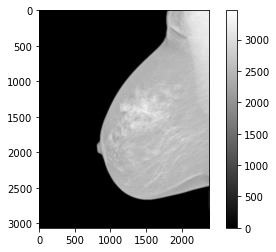

In [ ]:
dcm = pydicom.dcmread('/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/10215/1345293036.dcm')
print(dcm.pixel_array.shape)
plt.imshow(dcm.pixel_array, cmap='gray')

plt.colorbar()
plt.show()

(512, 512, 1)


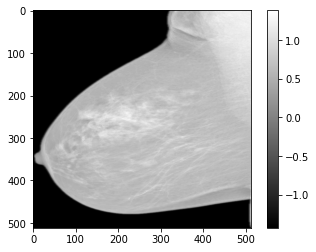

In [ ]:
img = dl.read_and_preprocess('/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/10215', img_size=(512, 512, 1), image_id=1345293036, normalize=(-1, 1))
print(img.shape)
plt.imshow(img.numpy(), cmap='gray')

plt.colorbar()
plt.show()

(5355, 4915)


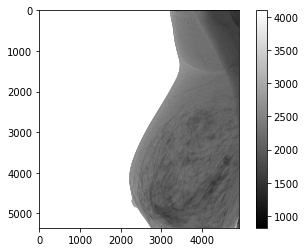

In [ ]:
dcm = pydicom.dcmread('/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/56125/100423288.dcm')
print(dcm.pixel_array.shape)
plt.imshow(dcm.pixel_array, cmap='gray')

plt.colorbar()
plt.show()

(512, 512, 1)


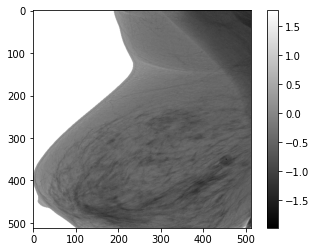

In [ ]:
img = dl.read_and_preprocess('/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/56125', img_size=(512, 512, 1), image_id=100423288, normalize=(-1, 1))
print(img.shape)
plt.imshow(img.numpy(), cmap='gray')

plt.colorbar()
plt.show()

# Determining the optimal no. of components using cross-validation

In [ ]:
sample_splitter.train

{50396: [662258688, 1837239038, 450873115, 2003084852],
 4897: [513273556, 1999718230, 1199778782, 1671045322],
 56564: [443242450, 679184119, 508000330, 1651764225],
 532: [1031466118, 1882220486, 821136751, 1502984041],
 10215: [1856209291, 2114415931, 328866680, 1345293036],
 23643: [694225462, 1879604768, 366903286, 966753341],
 60880: [2732265, 898458020, 1424550654, 267832019, 896794279, 1769052392],
 42826: [655795684, 974383583, 362353406, 1727396894]}

In [ ]:
sample_splitter.test

{22403: [17699901, 696903152, 1378510365, 1662359882],
 43781: [517127553, 1864066468, 1002661017, 1808358804]}

In [ ]:
# image id of all sample training set
train_img_ids = [id for k, v in sample_splitter.train.items() for id in v]
print(len(train_img_ids))

34


In [ ]:
# image id of all sample test set
test_img_ids = [id for k, v in sample_splitter.test.items() for id in v]
print(len(test_img_ids))

8


## Principal component analysis

In [ ]:
BATCH_SIZE = 34 # limitation: n_components must be less or equal to the batch number of samples
IMG_SIZE = (32, 32, 1)
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

img_gen = dl.ImgGenerator(
    list_IDs = train_img_ids,
    patient_img_dict = splitter.train,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (-1, 1)
    )

ipca = fex.train_feature_extractor(
    img_gen = img_gen,
    model_name = 'PCA',
    n_components=None,
    save_path=None,
    verbose=True
    )

Initialized PCA with n_components = None
--Training batch  1


In [ ]:
ipca.n_components_

34

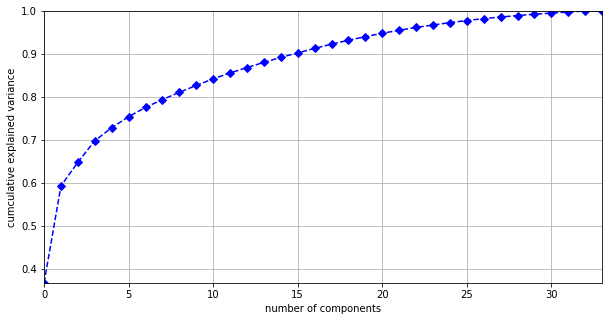

In [ ]:
# IMG_SIZE = (32, 32, 1)
fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(ipca.explained_variance_ratio_.cumsum(), marker='D', linestyle="--", color='blue')
axs.set_xlabel('number of components')
axs.set_ylabel('cumculative explained variance')
axs.margins(x=0,y=0)
plt.grid(axis='both')
plt.show()
# 8 components

In [ ]:
# evaluate on test set
BATCH_SIZE = 2

img_gen = dl.ImgGenerator(
    list_IDs = test_img_ids,
    patient_img_dict = splitter.train,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (-1, 1)
    )

explained_var, reconstruction_err = fex.evaluate_feature_extractor(img_gen, ipca, verbose=True)

--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
>> Calculating explained variance...
-->  0.5609024240362132
>> Calculating reconstruction error...
-->  0.2444853451098816


**Validate** (Checking generalizability)

In [ ]:
sample_cv_img[4]['validate']

[694225462, 1879604768, 366903286, 966753341]

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

N_COMPONENTS = 4 # limitation: in training n_components must be less or equal to the batch number of samples
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

ipca_model, explained_var, reconstruction_err = fex.cv_train_feature_extractor(
        cv_img = sample_cv_img,
        patient_img_dict = sample_splitter.train,
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (-1, 1),
        random_state = RANDOM_STATE,
        model_name = 'PCA',
        n_components = N_COMPONENTS, 
        extractor_path = EXTRACTOR_PATH,
        verbose = True,
        evaluate = True,
        return_none = False    
        )

Fold:  0
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_0.pkl
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  0.0648261160366192
>> Calculating reconstruction error...
-->  0.37678475001007644
Fold:  1
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_1.pkl
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  0.6287962433424605
>> Calculating reconstruction error...
-->  0.392559456645368
Fold:  2
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_2.pkl
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  0.5421154701789761
>> Calculating r

In [ ]:
explained_var

{0: 0.0648261160366192,
 1: 0.6287962433424605,
 2: 0.5421154701789761,
 3: -0.42920470004346556,
 4: -0.9397062118524466}

In [ ]:
reconstruction_err

{0: 0.37678475001007644,
 1: 0.392559456645368,
 2: 0.34607078685529663,
 3: 0.5403723544998816,
 4: 0.5437159686604421}

## Non-negative matrix factorization

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = (32, 32, 1)
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

img_gen = dl.ImgGenerator(
    list_IDs = train_img_ids,
    patient_img_dict = splitter.train,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (0, 1)  # nmf input must be non-negative
    )

n_components_range = [2, 3, 5, 8, 10, 15, 20]
reconstruction_errs = {}
explained_vars = {}

for n_components in n_components_range:
  nmf = fex.train_feature_extractor(
      img_gen = img_gen,
      model_name = 'NMF',
      n_components=None,
      save_path=None,
      verbose=True
      )
  
  explained_var, reconstruction_err = fex.evaluate_feature_extractor(img_gen, nmf, verbose=True)
  explained_vars[n_components] = explained_var
  reconstruction_errs[n_components] = reconstruction_err


Initialized NMF with n_components = None
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
>> Calculating explained variance...
-->  0.8087827698640255
>> Calculating reconstruction error...
-->  0.08301556911881398
Initialized NMF with n_components = None
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
>> Calculating explained variance...
-->  0.8079683568264953
>> Calculating reconstruction error...
-->  0.08300239562094892
Initialized NMF with n_components = None
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--T

In [ ]:
explained_vars

{2: 0.8087827698640255,
 3: 0.8079683568264953,
 5: 0.8049868638245656,
 8: 0.8041307292713337,
 10: 0.8056650765673172,
 15: 0.8059780197930353,
 20: 0.8047720152005551}

In [ ]:
reconstruction_errs

{2: 0.08301556911881398,
 3: 0.08300239562094892,
 5: 0.08419164672945283,
 8: 0.08435155633018951,
 10: 0.08408818166262791,
 15: 0.08374394999872607,
 20: 0.08382556052398048}

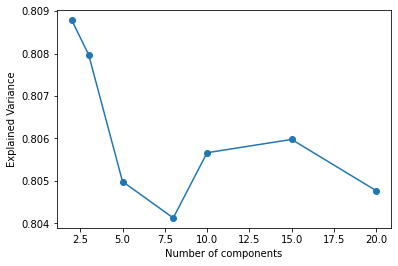

In [ ]:
plt.plot(n_components_range, explained_vars.values(), 'o-')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.show()
# 3 components

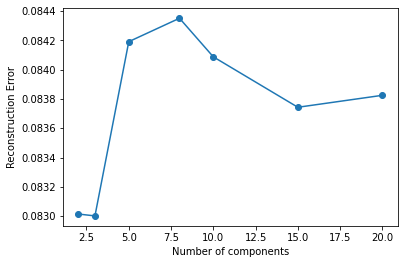

In [ ]:
plt.plot(n_components_range, reconstruction_errs.values(), 'o-')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.show()
# 3 components

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

N_COMPONENTS = 3
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

nmf_model, explained_var, reconstruction_err = fex.cv_train_feature_extractor(
        cv_img = sample_cv_img,
        patient_img_dict = sample_splitter.train,
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (0, 1),
        random_state = RANDOM_STATE,
        model_name = 'NMF',
        n_components = N_COMPONENTS, 
        extractor_path = EXTRACTOR_PATH,
        verbose = True,
        evaluate = True,
        return_none = False    
        )

Fold:  0
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_0.pkl
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  -inf
>> Calculating reconstruction error...
-->  0.31276754408536234
Fold:  1
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_1.pkl


/content/feature_extraction.py:106: RuntimeWarning: divide by zero encountered in true_divide
  explained_var = np.mean(1 - (diff_stats.var/batch_stats.var))


--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  0.27072889480208673
>> Calculating reconstruction error...
-->  0.13483826226948006
Fold:  2
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_2.pkl
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
>> Calculating explained variance...
-->  0.7246715341102962
>> Calculating reconstruction error...
-->  0.1659581127025162
Fold:  3
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_3.pkl
--Transforming batch  1
---Reconstructing batch
>> Calculating explained variance...
-->  -inf
>> Calculating reconstruction error...
-->  0.512565922916129
Fold:  4
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_4.pkl


/content/feature_extraction.py:106: RuntimeWarning: divide by zero encountered in true_divide
  explained_var = np.mean(1 - (diff_stats.var/batch_stats.var))


--Transforming batch  1
---Reconstructing batch
>> Calculating explained variance...
-->  -inf
>> Calculating reconstruction error...
-->  0.4026220969572296


/content/feature_extraction.py:106: RuntimeWarning: divide by zero encountered in true_divide
  explained_var = np.mean(1 - (diff_stats.var/batch_stats.var))


In [ ]:
explained_var

{0: -inf, 1: 0.27072889480208673, 2: 0.7246715341102962, 3: -inf, 4: -inf}

In [ ]:
reconstruction_err

{0: 0.31276754408536234,
 1: 0.13483826226948006,
 2: 0.1659581127025162,
 3: 0.512565922916129,
 4: 0.4026220969572296}

# Example training pipelines

Note: There is a bug in keras/tensorflow 2.9 and 2.10, which causes some preprocess layers to be extremly slow: https://github.com/tensorflow/tensorflow/issues/56242

For speed, try the model without the rescaling layer, or use Tensorflow version 2.8.3 or older.

## Augmentation + CNN

In [ ]:
IMG_SIZE = (32, 32, 1)

model_layers = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 8)                 86536     
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                      

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_augment'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = True,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1), 

    feature_extractor_name = None,
    n_components = None,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

NameError: ignored

Using distribute strategy

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 735684540493074682
 xla_global_id: -1]

In [ ]:
strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.ReductionToOneDevice()
    )

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


Only 1 device available cannot use distribute strategy

In [ ]:
# EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
# BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

# EPOCH = 1 
# BATCH_SIZE = 4 
# IMG_SIZE = (32, 32, 1)
# CORES = 4
# RANDOM_STATE = 42 # the random state that used to create cv splits
# LEARNING_RATE = 0.001
# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]


# CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_augment'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#      filepath = CHECKPOINT_PATH,
#      save_weights_only = False,
#      monitor = 'val_auc',
#      mode = 'max',
#      save_best_only = True
#      )


# history = rm.run_cv_training(
#     model_layers = model_layers,
#     cv_img = sample_cv_img,

#     augment_layers = True,
#     base_model = None,
#     trainable = False,
#     loss_func = tf.keras.losses.BinaryCrossentropy(),
#     optimizer = keras.optimizers.Adam(),
#     metrics = METRICS,

#     label_img_dict = sample_label_by_img,
#     patient_img_dict = splitter.train,
#     basepath = BASEPATH,
#     batch_size = BATCH_SIZE, 
#     img_size = (IMG_SIZE[0], IMG_SIZE[1]),
#     n_classes = 2,
#     shuffle = True,
#     normalize = (-1, 1), 

#     feature_extractor_name = None,
#     n_components = None,
#     extractor_path = EXTRACTOR_PATH,
#     random_state = RANDOM_STATE,

#     checkpoint_path = CHECKPOINT_PATH,
#     strategy = tf.distribute.MirroredStrategy(),
#     epoch = EPOCH,
#     callbacks = None,
#     use_multiprocessing = CORES,
#     workers = 1,
#     verbose = 1,

#     return_none = False
#     )

### Visualization: Grad-CAMs
Codes in this section is from a tutorial https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353

In [ ]:
# from random import shuffle 
# from tensorflow.python.keras.utils.data_utils import Sequence
#from tensorflow.keras.models import Model

In [ ]:
# def GradCam(model, img_array, layer_name, eps=1e-8):
#     '''
#     Creates a grad-cam heatmap given a model and a layer name contained with that model

#     Args:
#       model: tf model
#       img_array: (img_width x img_width) numpy array
#       layer_name: str

#     Returns 
#       uint8 numpy array with shape (img_height, img_width)

#     '''

#     gradModel = keras.models.Model(
# 			inputs=[model.inputs],
# 			outputs=[model.get_layer(layer_name).output, model.output]
#       )
    
#     with tf.GradientTape() as tape:
# 			# cast the image tensor to a float-32 data type, pass the
# 			# image through the gradient model, and grab the loss
# 			# associated with the specific class index
#       inputs = tf.cast(img_array, tf.float32)
#       (convOutputs, predictions) = gradModel(inputs)
#       loss = predictions[:, 0]

# 		# use automatic differentiation to compute the gradients
#     grads = tape.gradient(loss, convOutputs)
    
#     # compute the guided gradients
#     castConvOutputs = tf.cast(convOutputs > 0, "float32")
#     castGrads = tf.cast(grads > 0, "float32")
#     guidedGrads = castConvOutputs * castGrads * grads

# 		# the convolution and guided gradients have a batch dimension
# 		# (which we don't need) so let's grab the volume itself and
# 		# discard the batch
#     convOutputs = convOutputs[0]
#     guidedGrads = guidedGrads[0]

#     # compute the average of the gradient values, and using them
# 		# as weights, compute the ponderation of the filters with
# 		# respect to the weights
#     weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
#     cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
#     # grab the spatial dimensions of the input image and resize
# 		# the output class activation map to match the input image
# 		# dimensions
#     (w, h) = (img_array.shape[2], img_array.shape[1])
#     heatmap = cv2.resize(cam.numpy(), (w, h))

# 		# normalize the heatmap such that all values lie in the range
# 		# [0, 1], scale the resulting values to the range [0, 255],
# 		# and then convert to an unsigned 8-bit integer
#     numer = heatmap - np.min(heatmap)
#     denom = (heatmap.max() - heatmap.min()) + eps
#     heatmap = numer / denom
#     # heatmap = (heatmap * 255).astype("uint8")

# 		# return the resulting heatmap to the calling function
#     return heatmap


def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    layer_output = layer_output[0]
    heatmap = layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
# def sigmoid(x, a, b, c):
#     return c / (1 + np.exp(-a * (x-b)))

# def superimpose(img_bgr, cam, thresh, emphasize=False):  
#     '''
#     Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
#     Args:
#       image: (img_width x img_height x 3) numpy array
#       grad-cam heatmap: (img_width x img_width) numpy array
#       threshold: float
#       emphasize: boolean

#     Returns 
#       uint8 numpy array with shape (img_height, img_width, 3)

#     '''
#     heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
#     if emphasize:
#         heatmap = sigmoid(heatmap, 50, thresh, 1)
#     heatmap = np.uint8(255 * heatmap)
#     # heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
#     hif = .8
#     superimposed_img = heatmap * hif + img_bgr
#     superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
#     # superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
#     return superimposed_img#_rgb

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    #superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    plt.matshow(superimposed_img)

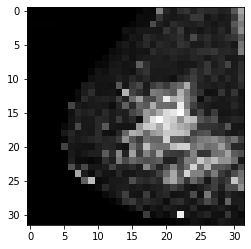

In [ ]:
IMG_SIZE = (32, 32, 1)

img = dl.read_and_preprocess(
    '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/60880',
    img_size=IMG_SIZE,
    image_id=267832019,
    normalize=(-1, 1)
    )

plt.imshow(img.numpy(), cmap='gray')
plt.show()

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Capstone/Models/checkpoint_augment/ckpt-1')
pred_model = model.get_layer('sequential_2')
pred_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense_3 (Dense)             (None, 8)                 86536     
                                                                 
 dense_4 (Dense)             (None, 2)                 18        
                                                      

In [ ]:
pred_model.predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 2s 2s/step


array([[1.0000000e+00, 4.7858842e-36]], dtype=float32)

In [ ]:
sample_meta[sample_meta['image_id']==267832019]['cancer'] # correct prediction

47301    0
Name: cancer, dtype: int64

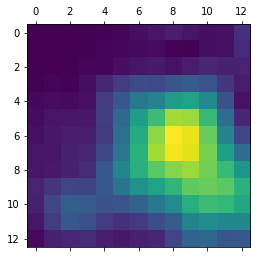

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array=np.expand_dims(img, axis=0), model=pred_model, layer_name='conv2d_1')

# Display heatmap
plt.matshow(heatmap)
plt.show()

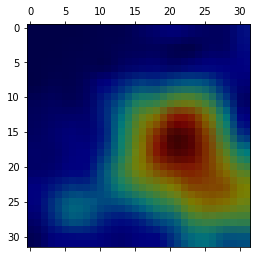

In [ ]:
save_and_display_gradcam(img.numpy(), heatmap, alpha=0.5)

In [ ]:
# def flatten_model(model_nested):
#     layers_flat = []
#     for layer in model_nested.layers:
#         try:
#             layers_flat.extend(layer.layers)
#         except AttributeError:
#             layers_flat.append(layer)
#     model_flat = keras.models.Sequential(layers_flat)
#     return model_flat

# flattened_model = flatten_model(model)
# # flattened_model.layers
# flattened_model.build(input_shape=(None, 32, 32, 1))
# flattened_model.summary()

## PCA + NN

Train PCA or load pre-trained model with pre-determined no. of components on the training split of each cross-validation fold

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits

N_COMPONENTS = 4 # limitation: must be less than or equal to batch size

fex.cv_train_feature_extractor(
        cv_img = sample_cv_img,
        patient_img_dict = sample_splitter.train,
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (-1, 1),
        random_state = RANDOM_STATE,
        model_name = 'PCA',
        n_components = N_COMPONENTS, 
        extractor_path = EXTRACTOR_PATH,
        verbose = True,
        evaluate = False,
        return_none = True    
        )

Fold:  0
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_0.pkl
Fold:  1
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_1.pkl
Fold:  2
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_2.pkl
Fold:  3
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_3.pkl
Fold:  4
PCA model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/PCA_4_42_4.pkl


Test running on 1 fold

In [ ]:
feat_ext = pickle.load(open('/content/drive/MyDrive/Capstone/Models/PCA_4_42_0.pkl', 'rb'))

In [ ]:
train_gen, val_gen = rm.get_train_val_generators(
        sample_cv_img[0]['train'],
        sample_cv_img[0]['validate'],
        label_img_dict = sample_label_by_img,
        patient_img_dict = splitter.train, 
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        n_classes=2,
        shuffle=True,
        normalize=(-1, 1),
        feature_extractor=feat_ext
        )

In [ ]:
model_layers = keras.Sequential([
    keras.layers.Input(shape=(N_COMPONENTS,)), 
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 2)                 26        
                                                                 
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape = (N_COMPONENTS,),
    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = keras.metrics.AUC()
    )
model.summary()

Checkpoint path:  /content/checkpoint
---Checkpoint folder created:  /content/checkpoint
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 2)                 26        
                                                                 
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
        train_gen,
        epochs=1,
        callbacks=None,
        validation_data=val_gen,
        use_multiprocessing = False,
        workers = 1,
        verbose = 1
    )

6/6 [==============================] - ETA: 0s - loss: 3.6382 - auc: 0.0104    

6/6 [==============================] - 47s 9s/step - loss: 3.6382 - auc: 0.0104 - val_loss: 2.6497 - val_auc: 0.0000e+00


Run the model on full cross-validation folds

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4
N_COMPONENTS = 4 # limitation: must be less than or equal to batch size
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_pca'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = IMG_SIZE,
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1),

    feature_extractor_name = 'PCA',
    n_components = N_COMPONENTS,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

Fold:  0
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_pca
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_pca/ckpt-1
6/6 [==============================] - 45s 8s/step - loss: 0.2775 - tp: 22.0000 - fp: 2.0000 - tn: 22.0000 - fn: 2.0000 - accuracy: 0.9167 - precision: 0.9167 - recall: 0.9167 - auc: 0.9618 - prc: 0.9642 - val_loss: 0.1229 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  1
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_pca
---Checkpoint folder already exists
Restoring from /content/drive/MyDriv

## NMF + NN

Train NMF or load pre-trained model with pre-determined no. of components on the training split of each cross-validation fold

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits

N_COMPONENTS = 3 

fex.cv_train_feature_extractor(
        cv_img = sample_cv_img,
        patient_img_dict = sample_splitter.train,
        batch_size = BATCH_SIZE,
        basepath = BASEPATH,
        img_size = IMG_SIZE,
        normalize = (0, 1), # NMF input must be non-negative
        random_state = RANDOM_STATE,
        model_name = 'NMF',
        n_components = N_COMPONENTS, 
        extractor_path = EXTRACTOR_PATH,
        verbose = True,
        evaluate = False,
        return_none = True    
        )

Fold:  0
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_0.pkl
Fold:  1
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_1.pkl
Fold:  2
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_2.pkl
Fold:  3
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_3.pkl
Fold:  4
NMF model trained on this cross-validation fold already exist
--> /content/drive/MyDrive/Capstone/Models/NMF_3_42_4.pkl


In [ ]:
model_layers = keras.Sequential([
    keras.layers.Input(shape=(N_COMPONENTS,)), 
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                64        
                                                                 
 dense_6 (Dense)             (None, 12)                204       
                                                                 
 dense_7 (Dense)             (None, 2)                 26        
                                                                 
Total params: 294
Trainable params: 294
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (75, 75, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_nmf'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )

print(CHECKPOINT_PATH)
history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (0, 1), # NMF input must be non-negative

    feature_extractor_name = 'NMF',
    n_components = 3,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

/content/drive/MyDrive/Capstone/Models/checkpoint_nmf
Fold:  0
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_nmf
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_nmf/ckpt-1
6/6 [==============================] - 49s 8s/step - loss: 0.6138 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.5912 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  1
---Loading feature extractor...
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_nmf
---Checkpo

## Augmentation + Pre-trained CNN + NN

In [ ]:
# pre-trained models for feature extraction
IMG_SIZE = (75, 75, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [ ]:
IMG_SIZE = (75, 75, 1)

model_layers = keras.Sequential([
    keras.layers.Input(shape=(1, 1, 2048)),
    keras.layers.GlobalMaxPool2D(),
    keras.layers.Dense(2, activation='softmax')
])

model_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


Test running on 1 fold

In [ ]:
model = rm.make_or_restore_model(
    model_layers,
    # input_shape = , # already set in base_model
    augment_layers = False, # test without augmentation layers
    base_model = base_model,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = keras.metrics.AUC()
    )
model.summary()

Checkpoint path:  /content/checkpoint
---Checkpoint folder created:  /content/checkpoint
Creating a new model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 sequential_2 (Sequential)   (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits

train_gen, val_gen = rm.get_train_val_generators(
        sample_cv_img[0]['train'],
        sample_cv_img[0]['validate'],
        label_img_dict = sample_label_by_img,
        patient_img_dict = splitter.train, 
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        n_classes=2,
        shuffle=True,
        normalize=(-1, 1),
        feature_extractor='CNN'
        )

In [ ]:
history = model.fit(
        train_gen,
        epochs=1,
        callbacks=None,
        validation_data=val_gen,
        use_multiprocessing = False,
        workers = 1,
        verbose = 1
    )

6/6 [==============================] - 46s 8s/step - loss: 0.5975 - auc_1: 0.9531 - val_loss: 0.5733 - val_auc_1: 1.0000


Run the model on full cross-validation folds

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_vgg16'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = True,
    base_model = base_model,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1), 

    feature_extractor_name = 'CNN',
    n_components = None,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    checkpoint_path = CHECKPOINT_PATH,
    strategy = None,
    epoch = EPOCH,
    callbacks = None,
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

Fold:  0
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


6/6 [==============================] - ETA: 0s - loss: 0.0212 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

6/6 [==============================] - 69s 10s/step - loss: 0.0212 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0148 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  1
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


6/6 [==============================] - ETA: 0s - loss: 0.0082 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

6/6 [==============================] - 85s 15s/step - loss: 0.0082 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0023 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  2
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


6/6 [==============================] - ETA: 0s - loss: 0.0030 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

6/6 [==============================] - 74s 12s/step - loss: 0.0030 - tp: 24.0000 - fp: 0.0000e+00 - tn: 24.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0014 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 8.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  3
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


7/7 [==============================] - ETA: 0s - loss: 8.9064e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

7/7 [==============================] - 74s 9s/step - loss: 8.9064e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.7202e-04 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!
Fold:  4
---Feature extractor: Pre-trained CNN
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16
---Checkpoint folder already exists
Restoring from /content/drive/MyDrive/Capstone/Models/checkpoint_vgg16/ckpt-1


7/7 [==============================] - ETA: 0s - loss: 4.2396e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000

7/7 [==============================] - 77s 11s/step - loss: 4.2396e-04 - tp: 28.0000 - fp: 0.0000e+00 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 2.4600e-05 - val_tp: 4.0000 - val_fp: 0.0000e+00 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
>>> Finish training model!


### Hyperparameter tuning

In [ ]:
# pre-trained models for feature extraction
IMG_SIZE = (75, 75, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activatio

In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (75, 75, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

train_gen, val_gen = rm.get_train_val_generators(
        sample_cv_img[0]['train'],
        sample_cv_img[0]['validate'],
        label_img_dict = sample_label_by_img,
        patient_img_dict = splitter.train, 
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        n_classes=2,
        shuffle=True,
        normalize=(-1, 1),
        feature_extractor='CNN'
        )

In [ ]:
def build_model(hp):
  model = keras.Sequential([
      keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
      base_model
      ])

  # choose an optimal pooling type
  if hp.Choice('globalpooling', ['avg', 'max'])=='max':
      model.add(keras.layers.GlobalMaxPooling2D())
  else:
      model.add(keras.layers.GlobalAveragePooling2D())
      
  model.add(keras.layers.Dense(2, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = [keras.metrics.AUC(curve='PR', num_thresholds=100, name='pr_auc')]
    )

  return model

In [ ]:
import keras_tuner as kt
                                             
# HyperBand algorithm from keras tuner
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective('val_pr_auc', direction='max'),
    factor=3,
    max_epochs=5,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo'
)

tuner.search(
    train_gen,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_mean_avg_precision', patience=2)],
    validation_data=val_gen
    )

Trial 10 Complete [00h 03m 15s]
val_pr_auc: 1.0

Best val_pr_auc So Far: 1.0
Total elapsed time: 00h 25m 21s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
globalpooling (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/keras_tuner_demo
Showing 10 best trials
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: avg
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: avg
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.0
Trial summary
Hyperparameters:
globalpooling: max
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial

In [ ]:
# Get the top model.
best_model = tuner.get_best_models(num_models=1)[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


## Logistic regression model

In [ ]:
IMG_SIZE = (32, 32, 1)
L1 = 0.
L2 = 0.01

model_layers = keras.Sequential([
    keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1])), 
    keras.layers.Flatten(),
    keras.layers.Dense(2, # binary classification
                activation='sigmoid',
                kernel_regularizer=keras.regularizers.L1L2(l1=L1, l2=L2)
    )
])

model_layers.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                 2050      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EXTRACTOR_PATH = '/content/drive/MyDrive/Capstone/Models'
BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

EPOCH = 1 
BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
CORES = 4
RANDOM_STATE = 42 # the random state that used to create cv splits
LEARNING_RATE = 0.001
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


CHECKPOINT_PATH = '/content/drive/MyDrive/Capstone/Models/checkpoint_logit'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath = CHECKPOINT_PATH,
     save_weights_only = False,
     monitor = 'val_auc',
     mode = 'max',
     save_best_only = True
     )


history = rm.run_cv_training(
    model_layers = model_layers,
    cv_img = sample_cv_img,

    augment_layers = False,
    base_model = None,
    trainable = False,
    loss_func = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = METRICS,

    label_img_dict = sample_label_by_img,
    patient_img_dict = splitter.train,
    basepath = BASEPATH,
    batch_size = BATCH_SIZE, 
    img_size = (IMG_SIZE[0], IMG_SIZE[1]),
    n_classes = 2,
    shuffle = True,
    normalize = (-1, 1),

    feature_extractor_name = None,
    extractor_path = EXTRACTOR_PATH,
    random_state = RANDOM_STATE,

    strategy = None,
    epoch = EPOCH,
    callbacks = [model_checkpoint_callback],
    use_multiprocessing = False,
    workers = 1,
    verbose = 1,

    return_none = False
    )

Fold:  0
---No feature extractor
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/checkpoint
---Checkpoint folder already exists
Creating a new model...
6/6 [==============================] - 48s 8s/step - loss: 0.8030 - tp: 17.0000 - fp: 14.0000 - tn: 10.0000 - fn: 7.0000 - accuracy: 0.5625 - precision: 0.5484 - recall: 0.7083 - auc: 0.5564 - prc: 0.6045 - val_loss: 0.7359 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 4.0000 - val_fn: 2.0000 - val_accuracy: 0.6250 - val_precision: 0.6000 - val_recall: 0.7500 - val_auc: 0.5625 - val_prc: 0.5705
>>> Finish training model!
Fold:  1
---No feature extractor
---Creating training and validation data generators...
---Start runing model...
Checkpoint path:  /content/checkpoint
---Checkpoint folder already exists
Creating a new model...
6/6 [==============================] - 46s 8s/step - loss: 0.6361 - tp: 26.0000 - fp: 15.0000 - tn: 17.0000 - fn: 6.0000 - accuracy: 0.6719 - precision: 0.

In [ ]:
history[0].history # fold 0, 1 epoch

{'loss': [0.8030039668083191],
 'tp': [17.0],
 'fp': [14.0],
 'tn': [10.0],
 'fn': [7.0],
 'accuracy': [0.5625],
 'precision': [0.5483871102333069],
 'recall': [0.7083333134651184],
 'auc': [0.5564236044883728],
 'prc': [0.6044892072677612],
 'val_loss': [0.7358518838882446],
 'val_tp': [6.0],
 'val_fp': [4.0],
 'val_tn': [4.0],
 'val_fn': [2.0],
 'val_accuracy': [0.625],
 'val_precision': [0.6000000238418579],
 'val_recall': [0.75],
 'val_auc': [0.5625],
 'val_prc': [0.5705485343933105]}

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

BASEPATH = '/content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset'

BATCH_SIZE = 4 
IMG_SIZE = (32, 32, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits


f1 = {}

for fold in cv_img:

  print('Fold: ', fold)
  print('---Initializing model')
  rfc = RandomForestClassifier(
        n_estimators=2, 
        max_depth=5,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        max_leaf_nodes=None,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1,
        warm_start=True, # enable incremental learning
        max_samples=None
  )

  print('---Creating training and validation data generators')
  train_gen, val_gen = rm.get_train_val_generators(
          sample_cv_img[fold]['train'],
          sample_cv_img[fold]['validate'],
          label_img_dict = sample_label_by_img,
          patient_img_dict = splitter.train, 
          basepath=BASEPATH,
          batch_size=BATCH_SIZE,
          img_size=IMG_SIZE,
          n_classes=2,
          shuffle=True,
          normalize=(-1, 1),
          feature_extractor=None
          )

  print('---Start training model')
  for i, (X_train, y_train) in enumerate(train_gen):

    print('------Training batch ', i)
    X_train = X_train.reshape(BATCH_SIZE, -1) # flatten array from IMG_SIZE shape  
    y_train = y_train[:, 1] # the output is one-hot encoded, select only second column which is for cancer=1
    
    if i > 0:
      rfc.n_estimators = rfc.n_estimators + 2  
    rfc.fit(X_train, y_train)
    print('------Current n_estimators: ', rfc.n_estimators)

  print('---Evaluating model')
  f1_batch = []
  for i, (X_val, y_val) in enumerate(val_gen):

    X_val = X_val.reshape(BATCH_SIZE, -1) # flatten array from IMG_SIZE shape
    y_val = y_val[:, 1] # the output is one-hot encoded, select only second column which is for cancer=1

    y_pred = rfc.predict(X_val)
    score = f1_score(y_val, y_pred, labels=[0, 1])

    print('------F1-score of batch {}: {}'.format(i, score))
    f1_batch.append(score)

  f1[fold] = np.mean(f1_batch)
  print('>>> F1-score of fold {}: {}'.format(fold, f1[fold]))

print('Finish training model!')

Fold:  0
---Initializing model
---Creating training and validation data generators
---Start training model
------Training batch  0
------Current n_estimators:  2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  1
------Current n_estimators:  4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  2
------Current n_estimators:  6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  3
------Current n_estimators:  8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  4
------Current n_estimators:  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  5
------Current n_estimators:  12
---Evaluating model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------F1-score of batch 0: 0.0


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------F1-score of batch 1: 0.0
>>> F1-score of fold 0: 0.0
Fold:  1
---Initializing model
---Creating training and validation data generators
---Start training model
------Training batch  0
------Current n_estimators:  2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  1
------Current n_estimators:  4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  2
------Current n_estimators:  6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  3
------Current n_estimators:  8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  4
------Current n_estimators:  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  5
------Current n_estimators:  12
---Evaluating model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------F1-score of batch 0: 0.0


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------F1-score of batch 1: 0.0
>>> F1-score of fold 1: 0.0
Fold:  2
---Initializing model
---Creating training and validation data generators
---Start training model
------Training batch  0
------Current n_estimators:  2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  1
------Current n_estimators:  4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  2
------Current n_estimators:  6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  3
------Current n_estimators:  8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  4
------Current n_estimators:  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  5
------Current n_estimators:  12
---Evaluating model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------F1-score of batch 0: 0.0


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------F1-score of batch 1: 0.0
>>> F1-score of fold 2: 0.0
Fold:  3
---Initializing model
---Creating training and validation data generators
---Start training model
------Training batch  0
------Current n_estimators:  2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  1
------Current n_estimators:  4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  2
------Current n_estimators:  6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  3
------Current n_estimators:  8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  4
------Current n_estimators:  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  5
------Current n_estimators:  12


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  6
------Current n_estimators:  14
---Evaluating model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 out of  14 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------F1-score of batch 0: 0.0
>>> F1-score of fold 3: 0.0
Fold:  4
---Initializing model
---Creating training and validation data generators
---Start training model
------Training batch  0
------Current n_estimators:  2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  1
------Current n_estimators:  4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  2
------Current n_estimators:  6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  3
------Current n_estimators:  8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  4
------Current n_estimators:  10


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  5
------Current n_estimators:  12


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------Training batch  6
------Current n_estimators:  14
---Evaluating model


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished


------F1-score of batch 0: 0.0
>>> F1-score of fold 4: 0.0
Finish training model!


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 out of  14 | elapsed:    0.0s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
# Install TensorFlow Decision Forests
!pip install tensorflow_decision_forests

In [ ]:
import tensorflow_decision_forests as tfdf

tfdf.keras.RandomForestModel(
    
    max_depth = 16,
    max_num_nodes = None,
    min_examples = 5,
    num_trees = 300,
    name = None,

    random_seed = RANDOM_SEED,
    verbose = 1,
    num_threads = None,
    
    tuner = None,
    bootstrap_size_ratio = 1.0,
    bootstrap_training_dataset = True,
    sampling_with_replacement= True,
  
    sorting_strategy = 'PRESORT',
    distribute_strategy	= ,# The tf.distribute.Strategy this model was created under.
    
    # Control how classification trees vote.
    # If true, each tree votes for one class. If false, each tree vote for a distribution of classes.
    winner_take_all = False, 
    
)

# Model architecture

In [ ]:
IMG_SIZE = (1024, 1024, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

base_model.summary()

In [ ]:
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IMG_SIZE = (299, 299, 1)

base_model = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=True
    )

base_model.summary()

In [ ]:
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IMG_SIZE = (1024, 1024, 1)

base_model = keras.applications.ResNet50(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

# base_model.summary()
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
IMG_SIZE = (224, 224, 3)

base_model = keras.applications.ResNet50(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=True
    )

# base_model.summary()
keras.utils.plot_model(base_model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           